In [1]:
from dotenv import load_dotenv
import os

load_dotenv('../.env')
openai_api_key = os.environ["OPENAI_API_KEY"]

In [2]:
from langchain import hub
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI

In [3]:
tools = [TavilySearchResults(max_results=1)]

In [4]:
# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/openai-tools-agent")

c:\Users\simja\anaconda3\envs\peft\lib\site-packages\langsmith\client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [5]:
# Choose the LLM that will drive the agent
# Only certain models support this
llm = ChatOpenAI(model="gpt-3.5-turbo-1106", temperature=0)

# Construct the OpenAI Tools agent
agent = create_openai_tools_agent(llm, tools, prompt)

In [6]:
# Create an agent executor by passing in the agent and tools
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [7]:
agent_executor.invoke({"input": "what is LangChain?"})



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'LangChain'}`


[{'url': 'https://en.wikipedia.org/wiki/LangChain', 'content': 'In October 2023 LangChain introduced LangServe, a deployment tool designed to facilitate the transition from LCEL (LangChain Expression Language) prototypes to production-ready applications.[5]\nIntegrations[edit]\nAs of March 2023, LangChain included integrations with systems including Amazon, Google, and Microsoft Azure cloud storage; API wrappers for news, movie information, and weather; Bash for summarization, syntax and semantics checking, and execution of shell scripts; multiple web scraping subsystems and templates; few-shot learning prompt generation support; finding and summarizing "todo" tasks in code; Google Drive documents, spreadsheets, and presentations summarization, extraction, and creation; Google Search and Microsoft Bing web search; OpenAI, Anthropic, and Hugging Face language models; iFixit re

{'input': 'what is LangChain?',
 'output': 'LangChain is an open source project that was launched in October 2022 by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, LangChain incorporated and the new startup raised over $20 million in funding at a valuation of at least $200 million from venture firm Sequoia Capital, a week after announcing a $10 million seed investment from Benchmark. LangChain introduced LangServe, a deployment tool designed to facilitate the transition from LCEL (LangChain Expression Language) prototypes to production-ready applications. The project quickly garnered popularity, with improvements from hundreds of contributors on GitHub, trending discussions on Twitter, lively activity on the project\'s Discord server, many YouTube tutorials, and meetups in San Francisco and London. As of April 2023, it can read from more than 50 document types and data sources. LangChain includes integrations with systems including Amazon,

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [5]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [6]:
graph_builder.add_edge(START, "chatbot")

In [7]:
graph_builder.add_edge("chatbot", END)

In [8]:
graph = graph_builder.compile()

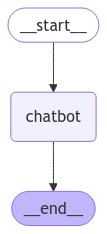

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [10]:
while True:
    user_input = input("User: ")
    print("User: "+ user_input)
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1])

User: Hello?
Assistant: 

AI: Hello! How can I assist you?
User: How are you?
Assistant: 

AI: I am an AI language model created by OpenAI. I do not have emotions or physical sensations, so I cannot feel or experience things like a human does. However, I am functioning properly and ready to assist you with any questions or tasks you may have. How can I help you?
User: quit
Goodbye!


In [28]:
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI

tools = [TavilySearchResults(max_results=1)]
tool_node = ToolNode(tools)
model = ChatOpenAI(model='gpt-4o-mini', temperature=0).bind_tools(tools)

In [15]:
from typing import Literal

def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    
    return END

In [16]:
# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [17]:
# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

In [18]:
# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

In [19]:
# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the fuction that will determine which node is called next.
    should_continue,
)

In [20]:
# We now add a normal edge from 'tools' to 'agent'.
# This means 

workflow.add_edge("tools", "agent")

In [21]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [22]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [29]:
model.invoke('hello?')

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 81, 'total_tokens': 91, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e9627b5346', 'finish_reason': 'stop', 'logprobs': None}, id='run-71f8f958-983b-4295-b118-5c125f273edb-0', usage_metadata={'input_tokens': 81, 'output_tokens': 10, 'total_tokens': 91})

: 